# EcoFOCIpy PostQC example to update netcdf file

see [EcoFOCIpy_sbe_UAF.ipynb](EcoFOCIpy_sbe_UAF.ipynb) for initial processing and formatting.  Data would have been convertted from raw instrument format to csv files, initial dirty plots created and a meta-data rich and meta-data poor dataset would have been created.  The metadata poor csv file is used for the initial preliminary data archive, the metadata rich netcdf file is used for QC procedures and eventual final data archive.

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history

- **TODO** Programmatically simplify following tools

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml

import pandas as pd
import xarray as xr
import datetime
import EcoFOCIpy.io.erddap as erddap

import EcoFOCIpy.metaconfig.load_config as load_config

In [135]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2024/Moorings/24ckp3a/working/'
filename = '24ckp3a_s37_0039m.nc'

### Post Manual QC load data and rebuild nc file

- using excel for a few points or a dynamic web map for multiple (a tool on ecofoci-field.pmel.noaa.gov) or any other method to identify spikes
- remove values above 32psu and below 30psu

**NOTE** if you use excel, be cautious about how your time is formatted (its important) - use custom formatting and make it of the form `yyyy-mm-ddTHH:MM:SSZ` to assure proper read in to xarray

*TODO:* use erddap hosted data 

In [136]:
# this loads the initial working netcdf file
wop_nc_qc = xr.load_dataset(user_data_dir+filename)

In [137]:
wop_nc_qc

<xarray.Dataset> Size: 283kB
Dimensions:       (time: 8832, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time          (time) datetime64[ns] 71kB 2024-08-17T18:00:00 ... 2025-08-...
  * latitude      (latitude) float64 8B 71.83
  * longitude     (longitude) float64 8B -166.0
  * depth         (depth) float64 8B 39.0
Data variables:
    temperature   (time, depth, latitude, longitude) float64 71kB 0.9987 ... ...
    conductivity  (time, depth, latitude, longitude) float64 71kB 2.791 ... 2...
    salinity      (time, depth, latitude, longitude) float64 71kB 32.41 ... 3...
Attributes: (12/33)
    Latitude_DegMMddW:                      71 49.86 N
    Longitude_DegMMddN:                     166 0.87 W
    MooringID:                              24CKP-3A
    platform_deployment_date:               2024-08-17T18:00:00Z
    platform_deployment_cruise_name:        SKQ202412S
    platform_recovery_date:                 2025-08-20T17:08:01Z
    ...                                     ...
    InstrumentSerialNumber:                 1804
    InstrumentType:                         SBE-37
    date_created:                           2025-09-22T11:28:14Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.

In [138]:
# this reads the previous csv and assumes you've made modifications to the content but not the structure (record length or variable names)
df_qc = pd.read_csv(user_data_dir+filename.replace('nc','to_edit.csv'), index_col=['time','depth','latitude','longitude']) #order is important

In [139]:
df_qc

,,,,temperature,conductivity,salinity
time,depth,latitude,longitude,,,
2024-08-17 18:00:00,39.0,71.831,-166.0145,0.9987,2.79108,32.4136
2024-08-17 19:00:00,39.0,71.831,-166.0145,0.9846,2.78967,32.4103
2024-08-17 20:00:00,39.0,71.831,-166.0145,0.9517,2.78664,32.4057
2024-08-17 21:00:00,39.0,71.831,-166.0145,0.9880,2.78906,32.3989
2024-08-17 22:00:00,39.0,71.831,-166.0145,1.0780,2.79590,32.3927
...,...,...,...,...,...,...
2025-08-20 13:00:00,39.0,71.831,-166.0145,-0.5555,2.64054,32.0778
2025-08-20 14:00:00,39.0,71.831,-166.0145,-0.3178,2.65687,32.0441
2025-08-20 15:00:00,39.0,71.831,-166.0145,-0.2977,2.65914,32.0530


In [140]:
#replace original data with editied data
for var in wop_nc_qc.variables:
    if var not in ['time','latitude','longitude','depth'] + []:
        print(var)
        try:
            wop_nc_qc[var].values=xr.Dataset.from_dataframe(df_qc)[var]
            print(f'{var} success')
        except:
            pass

temperature
temperature success
conductivity
conductivity success
salinity
salinity success


In [141]:
#drop oxy conc for oxygen
# wop_nc_qc = wop_nc_qc.drop('oxy_conc')

### Update global attributes

In [142]:
wop_nc_qc.attrs.update({'QC_indicator': 'ProbablyGood'})
try:
    wop_nc_qc.attrs.update({'history':(wop_nc_qc.history + "\nQC'd: "+ str(datetime.datetime.today()))})
except:
    pass

In [143]:
wop_nc_qc.attrs.update({'date_modified':str(datetime.datetime.today())})

In [144]:
wop_nc_qc.to_netcdf(user_data_dir+filename,format="NETCDF3_CLASSIC",encoding={'time':{'units':'days since 1900-01-01'}})

/var/folders/6r/n_mpcj7d7pdf9ncqvjy5vb8c0000jm/T/ipykernel_10539/664318075.py:1: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 1900-01-01'. Resolution of 'hours' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  wop_nc_qc.to_netcdf(user_data_dir+filename,format="NETCDF3_CLASSIC",encoding={'time':{'units':'days since 1900-01-01'}})


In [145]:
wop_nc_qc

<xarray.Dataset> Size: 283kB
Dimensions:       (time: 8832, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time          (time) datetime64[ns] 71kB 2024-08-17T18:00:00 ... 2025-08-...
  * latitude      (latitude) float64 8B 71.83
  * longitude     (longitude) float64 8B -166.0
  * depth         (depth) float64 8B 39.0
Data variables:
    temperature   (time, depth, latitude, longitude) float64 71kB 0.9987 ... ...
    conductivity  (time, depth, latitude, longitude) float64 71kB 2.791 ... 2...
    salinity      (time, depth, latitude, longitude) float64 71kB 32.41 ... 3...
Attributes: (12/33)
    Latitude_DegMMddW:                      71 49.86 N
    Longitude_DegMMddN:                     166 0.87 W
    MooringID:                              24CKP-3A
    platform_deployment_date:               2024-08-17T18:00:00Z
    platform_deployment_cruise_name:        SKQ202412S
    platform_recovery_date:                 2025-08-20T17:08:01Z
    ...                                     ...
    InstrumentSerialNumber:                 1804
    InstrumentType:                         SBE-37
    date_created:                           2025-09-22T11:28:14Z
    date_modified:                          2025-09-24 14:38:24.344675
    QC_indicator:                           ProbablyGood
    history:                                Trimmed to deployment.\nQC'd: 202...

## Plot against CTD if necessary

In [13]:
import pandas as pd
import EcoFOCIpy.io.erddap as erddap

url = "http://ecofoci-field.pmel.noaa.gov:8080/erddap"

erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [60]:
depcast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2103',qclevel='final',concastno='027')
reccast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2206',qclevel='final',concastno='022')

In [61]:
depcast.columns = [x.split(' ')[0] for x in depcast.columns]
reccast.columns = [x.split(' ')[0] for x in reccast.columns]

In [62]:
depcast.pressure = depcast.pressure.round()
reccast.pressure = reccast.pressure.round()

some variable names switch between preliminary and final... this will eventually be resolved

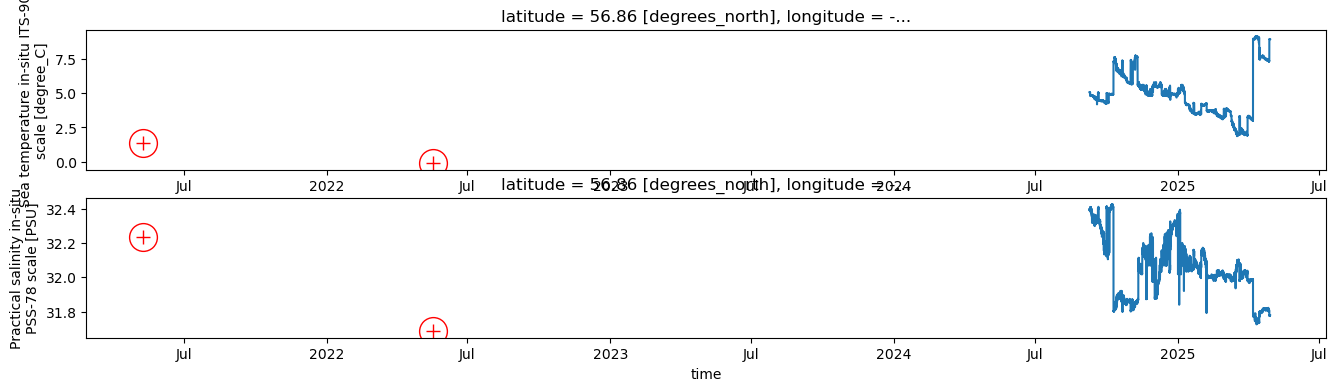

In [47]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
# depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])
depth = 39

fig, ax = plt.subplots(2,figsize=(16, 4))
wop_nc_qc.temperature.plot(x="time",hue="depth",ax=ax[0], add_legend=False);
# wop_nc_qc.oxy_temperature.plot(x="time",hue="depth",ax=ax[0], add_legend=False);
ax[0].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['temperature_ch1'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax[0].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['temperature_ch1'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
ax[0].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
        reccast[reccast['pressure'] == depth]['temperature_ch1'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax[0].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
        reccast[reccast['pressure'] == depth]['temperature_ch1'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

wop_nc_qc.salinity.plot(x="time",hue="depth",ax=ax[1], add_legend=False);
ax[1].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['salinity_ch1'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax[1].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['salinity_ch1'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
ax[1].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
        reccast[reccast['pressure'] == depth]['salinity_ch1'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax[1].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
        reccast[reccast['pressure'] == depth]['salinity_ch1'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

